In [ ]:
!git clone https://github.com/danielriosgarza/simulation_envs.git

Cloning into 'simulation_envs'...
remote: Enumerating objects: 518, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 518 (delta 79), reused 183 (delta 53), pack-reused 304 (from 1)
Receiving objects: 100% (518/518), 87.38 KiB | 1.68 MiB/s, done.
Resolving deltas: 100% (189/189), done.


In [ ]:
!python simulation_envs/scripts/db/make_schema.py /content/simulation_envs/files/db_tables/kombuchaDB_colab.sqlite3

/content/simulation_envs/files/db_tables/kombuchaDB_colab.sqlite3
Database created successfully at: /content/simulation_envs/files/db_tables/kombuchaDB_colab.sqlite3


In [ ]:
!python /content/simulation_envs/scripts/db/load_data.py /content/simulation_envs/files/db_tables/kombuchaDB_colab.sqlite3 /content/simulation_envs/files/db_tables/


Connected to database: /content/simulation_envs/files/db_tables/kombuchaDB_colab.sqlite3
Loading file: /content/simulation_envs/files/db_tables/elements.tsv into table: elements (Encoding: UTF-16)
Loading file: /content/simulation_envs/files/db_tables/metabolites.tsv into table: metabolites (Encoding: ascii)
Loading file: /content/simulation_envs/files/db_tables/metabolites2elements.tsv into table: metabolites2elements (Encoding: ascii)
Loading file: /content/simulation_envs/files/db_tables/kombucha_media.tsv into table: kombucha_media (Encoding: ascii)
Loading file: /content/simulation_envs/files/db_tables/species.tsv into table: species (Encoding: ascii)
Loading file: /content/simulation_envs/files/db_tables/feedingTerms.tsv into table: feedingTerms (Encoding: ascii)
Loading file: /content/simulation_envs/files/db_tables/feedingTerms2metabolites.tsv into table: feedingTerms2metabolites (Encoding: ascii)
Loading file: /content/simulation_envs/files/db_tables/subpopulations.tsv into ta

In [ ]:
!uv pip install pony

Using Python 3.11.13 environment at: /usr
Resolved 1 package in 126ms
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
Prepared 1 package in 58ms
Installed 1 package in 6ms
 + pony==0.7.19


In [ ]:
# Check GPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print("GPU Available!")
else:
    print("No GPU - Go to Runtime > Change runtime type > GPU")
import pandas as pd
import os
import sqlite3
from sqlite3 import Error
import chardet
import random

import sys
import plotly.io as pio
pio.renderers.default = 'colab'

import gymnasium as gym
from gymnasium import spaces
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import AdamW

import copy

from tqdm import tqdm


Device: cpu
No GPU - Go to Runtime > Change runtime type > GPU


In [ ]:
# Setup path to access core and db scripts
sys.path.append('/content/simulation_envs/scripts/db')
sys.path.append('/content/simulation_envs/scripts/core')
sys.path.append('/content/simulation_envs/scripts/files')

from readModelDB import get_database, createMetabolome, createBacteria
from mainClasses import *

ACETATE_IDX = 0
#add a pH function
def getpH(metabolome_concentration):
  pH= min(10, max(3, -0.0491*metabolome_concentration[ACETATE_IDX] + 6.6369))
  return pH

  # Load database
DATABASEFOLDER = '/content/simulation_envs/files/db_tables/'
DATABASENAME = 'kombuchaDB_colab.sqlite3'
DB = get_database(os.path.join(DATABASEFOLDER, DATABASENAME))

#Trained NN
TRAINED_NN_PTH = '/content/q_network_final.pth'

In [ ]:
def getReactor(simulTime = 1, SimulSteps = 100, dilution = 0, volume = 100):
  metabolome = createMetabolome(DB, mediaName='kombucha_media', pHFunc=getpH)
  metabolome_feed = createMetabolome(DB, mediaName='kombucha_media', pHFunc=getpH)

  microbiome = Microbiome({'bb': createBacteria(DB, speciesID='bb', mediaName='kombucha_media'),
                         'ki':createBacteria(DB, speciesID='ki', mediaName='kombucha_media')})
  microbiome_feed = Microbiome({'bb': createBacteria(DB, speciesID='bb', mediaName='kombucha_media'),
                              'ki':createBacteria(DB, speciesID='ki', mediaName='kombucha_media')})
  for i in microbiome_feed.subpopD:
    microbiome_feed.subpopD[i].count=0

  pulse = Pulse(metabolome_feed, microbiome_feed, 0, simulTime, SimulSteps, 0, 0, dilution,dilution)
  reactor = Reactor(microbiome, metabolome, [pulse], volume)
  return reactor

In [ ]:
def reward_function(reactor):
    target_ethanol = 10.0

    try:
        ethanol_idx = reactor.metabolome.metabolites.index('ethanol')
        ethanol_conc = reactor.metabolome.concentration[ethanol_idx]

        # Normalize deviation and invert: max reward = 1.0 at target
        deviation = abs(ethanol_conc - target_ethanol)
        reward = max(0.0, 1 - deviation / target_ethanol)  # between 0 and 1

        return reward
    except (ValueError, IndexError):
        return 0.0  # lowest reward if ethanol not found
    print(f"[DEBUG] Ethanol concentration: {ethanol_conc:.2f}")


In [ ]:
class KombuchaGymAction(Enum):
  INCREASE = 0
  DECREASE = 1

class KombuchaGym(gym.Env):
  metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 1}
  def __init__(self, max_steps = 240,
               reward_scale = 100,
               simulTime = 1,
               SimulSteps = 100,
               dilution = 0.5,
               volume = 100,
               render_mode = None,
               max_dilution = 60):
    super(KombuchaGym, self).__init__()
    self.metabolome_feed = self.current_step = 0
    self.max_steps = max_steps
    self.reward_scale = reward_scale
    self.render_mode = render_mode
    self.max_dilution = max_dilution
    self.unit_change = 0.01
    self.simulTime = simulTime
    self.SimulSteps = SimulSteps
    self.dilution = dilution
    self.volume = volume
    self.metabolome_feed = createMetabolome(DB, mediaName='kombucha_media', pHFunc=getpH)
    self.microbiome_feed = Microbiome({'bb': createBacteria(DB, speciesID='bb', mediaName='kombucha_media'),
                              'ki':createBacteria(DB, speciesID='ki', mediaName='kombucha_media')})
    for i in self.microbiome_feed.subpopD:
      self.microbiome_feed.subpopD[i].count=0
    self.reactor = getReactor(self.simulTime, self.SimulSteps, self.dilution, self.volume)
    self.reactor.simulate()
    self.action_space = spaces.Discrete(2)
    self.observation_space = spaces.Box(
        low=np.array([0.0]*12,  dtype=np.float32),
        high=np.array([np.inf]*12, dtype=np.float32),
        shape=(12,),
        dtype=np.float32
        )
    #self.episode_logs = []

  def reset(self):
    self.current_step = 0
    self.dilution     = 0.5
    self.reactor = getReactor(simulTime = 1, SimulSteps = 100, dilution = 0, volume = 100)
    self.reactor.simulate()
    self.episode_logs = []
    return self._get_observation(), {}

  def _get_observation(self):

    return self.reactor.get_states()

  def step(self, action):
    self.current_step += 1

    action_enum = KombuchaGymAction(action)
    if action_enum == KombuchaGymAction.INCREASE:
      self.dilution = min(self.max_dilution, self.dilution + self.unit_change)
    elif action_enum == KombuchaGymAction.DECREASE:
      self.dilution  = max(0, self.dilution - self.unit_change)
    microbiome = self.reactor.microbiome
    metabolome = self.reactor.metabolome
    pulse = [Pulse(self.metabolome_feed, self.microbiome_feed, 0, self.simulTime, self.SimulSteps, 0, 0, self.dilution,self.dilution)]
    self.reactor = Reactor(microbiome, metabolome, pulse, self.volume)
    self.reactor.simulate()

    subpop_counts = {k: v.count for k, v in self.reactor.microbiome.subpopD.items()}
    current_pH = getpH(self.reactor.metabolome.concentration)
    metabolite_conc = dict(zip(self.reactor.metabolome.metabolites, self.reactor.metabolome.concentration))
    dilution_level = self.dilution

    episode_info = {
          'step': self.current_step,
          'subpop_counts': subpop_counts,
          'pH': current_pH,
          'metabolite_concentrations': metabolite_conc,
          'dilution': dilution_level
      }
    self.episode_logs.append(episode_info)

    observation = self._get_observation()
    reward = self._get_reward()
    terminated = self._is_terminated()
    truncated = False
    info = episode_info
    return observation, reward, terminated, truncated, info
  """
    def _get_reward(self):
      return reward_function(self.reactor)/self.reward_scale
  """
  def _get_reward(self):
    return reward_function(self.reactor)


  def _is_terminated(self):
    return self.current_step >= self.max_steps


  def render(self):
    if self.render_mode == "human":
      self.reactor.makePlots()
    elif self.render_mode == "rgb_array":
      return self.reactor.makePlots()

In [ ]:
env = KombuchaGym(max_steps=10)
obs, _ = env.reset()
done = False
while not done:
  action = env.action_space.sample()
  obs, reward, done, truncated, info = env.step(action)
  print(f"Step {info['step']} - pH: {info['pH']:.2f}, Dilution: {info['dilution']:.2f}")
  print(f"Subpopulations: {info['subpop_counts']}")
  print(f"Metabolites: {info['metabolite_concentrations']}")
  print("-" * 50)
  print("\n=== Episode Summary ===")
  for entry in env.episode_logs:
    print(f"Step {entry['step']} - pH: {entry['pH']:.2f}, Dilution: {entry['dilution']:.2f}")
    print(f"Subpopulations: {entry['subpop_counts']}")
    print(f"Metabolites: {entry['metabolite_concentrations']}")
    print("-" * 50)

Step 1 - pH: 6.64, Dilution: 0.49
Subpopulations: {'bb1': np.float64(0.021196891691930675), 'bb2': np.float64(0.0098497608873509), 'bb6': np.float64(0.0004304203380320272), 'ki1': np.float64(0.008225132430280169), 'ki2': np.float64(0.009792777233787632), 'ki6': np.float64(0.011861826684603761)}
Metabolites: {'acetate': np.float64(3.5243646954613653e-06), 'ethanol': np.float64(6.389790729106736e-05), 'fructose': np.float64(0.011462403651209013), 'glucose': np.float64(0.011462403651209013), 'sucrose': np.float64(19.98850219715657)}
--------------------------------------------------

=== Episode Summary ===
Step 1 - pH: 6.64, Dilution: 0.49
Subpopulations: {'bb1': np.float64(0.021196891691930675), 'bb2': np.float64(0.0098497608873509), 'bb6': np.float64(0.0004304203380320272), 'ki1': np.float64(0.008225132430280169), 'ki2': np.float64(0.009792777233787632), 'ki6': np.float64(0.011861826684603761)}
Metabolites: {'acetate': np.float64(3.5243646954613653e-06), 'ethanol': np.float64(6.3897907

In [ ]:
import pandas as pd

# Convert random policy logs to DataFrame
random_logs = env.episode_logs
random_df = pd.DataFrame([
    {
        "step": entry["step"],
        "pH": entry["pH"],
        "dilution": entry["dilution"],
        **{f"subpop_{k}": v for k, v in entry["subpop_counts"].items()},
        **{f"metabolite_{k}": v for k, v in entry["metabolite_concentrations"].items()},
        "phase": "random"
    }
    for entry in random_logs
])


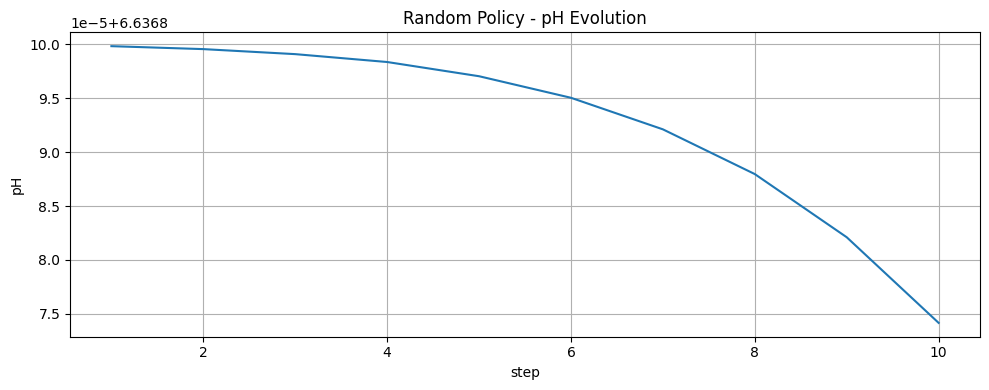

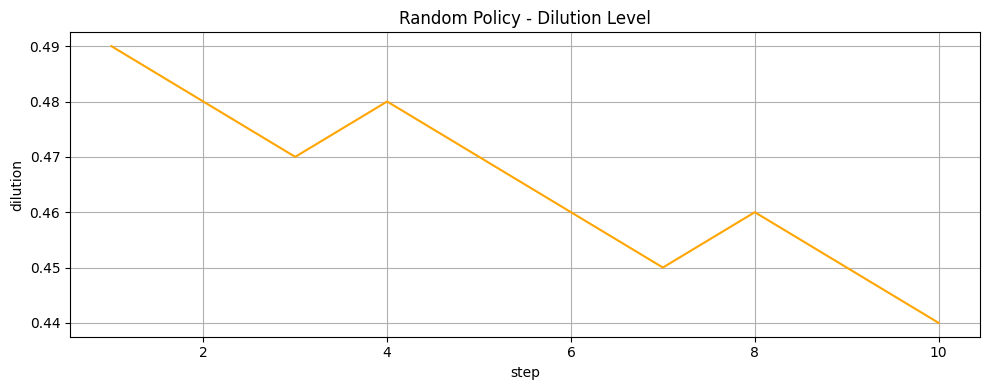

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot pH evolution
plt.figure(figsize=(10, 4))
sns.lineplot(data=random_df, x="step", y="pH")
plt.title("Random Policy - pH Evolution")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot dilution
plt.figure(figsize=(10, 4))
sns.lineplot(data=random_df, x="step", y="dilution", color="orange")
plt.title("Random Policy - Dilution Level")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
class PreprocessEnv(gym.ObservationWrapper):
  def __init__(self, env):
    super(PreprocessEnv, self).__init__(env)
  def reset(self):
    obs, _ = self.env.reset()
    return self._obs_to_flat_tensor(obs)

  def step(self, action):
    #action = action.item()
    #obs, reward, done, _, _ = self.env.step(action)
    obs, reward, terminated, truncated, info = self.env.step(action)
    reward = torch.tensor(reward).view(1,-1).float()
    terminated = torch.tensor(terminated).view(1,-1).int()
    truncated = torch.tensor(truncated).view(1,-1).int()
    #done = torch.tensor(done).view(1,-1).int()
    #return self._obs_to_flat_tensor(obs), reward, done, False, {}
    return self._obs_to_flat_tensor(obs), reward, terminated, truncated, info

  def _obs_to_flat_tensor(self, obs):
    grid_tensor = torch.tensor(obs).flatten()
    return torch.cat([grid_tensor]).unsqueeze(dim=0).float()

def policy(state, epsilon = 0):
  #random exploration
  if torch.rand(1) < epsilon:
    return torch.randint(action_dims, (1,1))
  #exploitation
  else:
    av = q_network(state).detach()
    return torch.argmax(av, dim = - 1, keepdim = True)

class ReplayMemory:
  #def __init__(self, capacity = 1000000):
  def __init__(self, capacity = 20000):
    self.capacity = capacity
    self.memory = []
    self.position = 0

  def insert(self, transition):
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = transition
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    assert self.can_sample(batch_size)
    batch = random.sample(self.memory, batch_size)
    batch = zip(*batch)
    return [torch.cat(items) for items in batch]

  def can_sample(self, batch_size):
    #return len(self.memory) >= batch_size * 10
    return len(self.memory) >= max(batch_size, 1000)

  def __len__(self):
    return len(self.memory)

def soft_update(target, source, tau = 0.005):
  for target_param, param in zip(target.parameters(), source.parameters()):
    #target_param.data.copy_(tau * param.data * (1.0 - tau) * target_param.data)
    target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

def deep_sarsa(q_network,
               policy,
               episodes,
               alpha=0.0003,
               batch_size = 64,
               gamma = 0.99):
  #optim = AdamW(q_network.parameters(), lr = alpha)
  optim = AdamW(q_network.parameters(), lr = alpha, weight_decay=1e-5)
  memory = ReplayMemory()
  stats = {'MSE Loss': [],
           'Returns': [],
           'Episodes': []}
  step_count = 0
  for episode in tqdm(range(1, episodes + 1)):
    epsilon = 1.0
    #step_count += 1
    #epsilon = max(0.05, 1.0 - episode/10000)
    epsilon = max(0.05, epsilon * 0.995) if episode > 1 else 1.0
    state = env.reset()
    done = False
    ep_return = 0
    while not done:
      action = policy(state, epsilon)
      next_state, reward, done, _, _ = env.step(action)
      memory.insert([state, action, reward, done, next_state])

      #if memory.can_sample(batch_size):
      if memory.can_sample(batch_size) and step_count % 4 == 0:
        state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
        qsa_b = q_network(state_b).gather(1, action_b)
        next_action_b = policy(next_state_b, epsilon)
        next_qsa_b = q_network(next_state_b).gather(1, next_action_b)
        target_b = reward_b + gamma * (1 - done_b) * next_qsa_b
        #loss = F.mse_loss(qsa_b, target_b)
        loss = F.smooth_l1_loss(qsa_b, target_b)
        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q_network.parameters(), max_norm=10)
        optim.step()

        #soft_update (check why)
        #soft_update(target_q_network, q_network, tau = 0.005)
        soft_update(target_q_network, q_network, tau=0.005)
        stats['MSE Loss'].append(loss.item())
        state = next_state
        #step_count += 1
        ep_return += reward.item()

    stats['Returns'].append(ep_return)
    stats['Episodes'].append(env.env.episode_logs)

    if episode % 10 == 0:
      plot_with_moving_average(stats['MSE Loss'], title="MSE Loss")
      plot_with_moving_average(stats['Returns'], title="Returns", plot_raw=False)
      save_q_network(q_network, "q_network_final.pth")
  return stats

def plot_with_moving_average(data, title, window=50, plot_raw = True):
    series = pd.Series(data)
    ma = series.rolling(window).mean()
    #plt.figure(figsize=(10, 4))
    if plot_raw:
      plt.plot(series, alpha=0.3, label='Raw')
    plt.plot(ma, label=f'Moving Avg (window={window})', linewidth=2)
    plt.title(title)
    plt.xlabel('Training Step')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def save_q_network(q_network, path=TRAINED_NN_PTH):
    torch.save(q_network.state_dict(), path)
    print(f"Saved q_network state_dict to: {path}")

def load_q_network(q_network, path=TRAINED_NN_PTH):
    if os.path.exists(path):
        q_network.load_state_dict(torch.load(path, weights_only=True))
        q_network.eval()
        print(f"Loaded q_network state_dict from: {path}")
    else:
        save_q_network(q_network, path=TRAINED_NN_PTH)
        print(f"No saved model found at: {path}")

In [ ]:
state_dims = 12
action_dims = 2
"""
q_network = nn.Sequential(
    nn.Linear(state_dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, action_dims)
)
"""
q_network = nn.Sequential(
    nn.Linear(state_dims, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, action_dims)
).to(device)
target_q_network = copy.deepcopy(q_network)
target_q_network = target_q_network.eval().to(device)

target_q_network

Sequential(
  (0): Linear(in_features=12, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
def run_q_network_policy_episode(env, q_network, max_steps=100):
    state = env.reset()
    episode_logs = []

    for _ in range(max_steps):
        if not isinstance(state, torch.Tensor):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        else:
            state_tensor = state

        q_values = q_network(state_tensor)
        q_action = torch.argmax(q_values, dim=1).item()

        state, reward, done, _, info = env.step(q_action)

        log = {
            "step": info["step"],
            "action_q_network": q_action,
            "reward": reward,
            "pH": info["pH"],
            "dilution": info["dilution"],
            "subpop_counts": info["subpop_counts"],
            "metabolite_concentrations": info["metabolite_concentrations"]
        }
        episode_logs.append(log)

        if done:
            break

    return episode_logs


In [ ]:
env_test = KombuchaGym(max_steps=50)
env_test = PreprocessEnv(env_test)

pre_training_logs = run_q_network_policy_episode(env_test, q_network, max_steps=50)

for entry in pre_training_logs:
    print(f"Step {entry['step']} - Action: {entry['action_q_network']}, Reward: {entry['reward'].item():.4f}")
    print(f"  pH: {entry['pH']:.2f}, Dilution: {entry['dilution']:.2f}")
    print(f"  Subpopulations: {entry['subpop_counts']}")
    print(f"  Metabolites: {entry['metabolite_concentrations']}")
    print("-" * 60)


Step 1 - Action: 1, Reward: 0.0000
  pH: 6.64, Dilution: 0.49
  Subpopulations: {'bb1': np.float64(0.021196891691930675), 'bb2': np.float64(0.0098497608873509), 'bb6': np.float64(0.0004304203380320272), 'ki1': np.float64(0.008225132430280169), 'ki2': np.float64(0.009792777233787632), 'ki6': np.float64(0.011861826684603761)}
  Metabolites: {'acetate': np.float64(3.5243646954613653e-06), 'ethanol': np.float64(6.389790729106736e-05), 'fructose': np.float64(0.011462403651209013), 'glucose': np.float64(0.011462403651209013), 'sucrose': np.float64(19.98850219715657)}
------------------------------------------------------------
Step 2 - Action: 1, Reward: 0.0000
  pH: 6.64, Dilution: 0.48
  Subpopulations: {'bb1': np.float64(0.03071935276962407), 'bb2': np.float64(0.009824141116429607), 'bb6': np.float64(0.0007343702910987068), 'ki1': np.float64(0.0074496563719979505), 'ki2': np.float64(0.009678895051638292), 'ki6': np.float64(0.012638466283397891)}
  Metabolites: {'acetate': np.float64(9.089

Loaded q_network state_dict from: /content/q_network_final.pth


  4%|▎         | 9/250 [01:07<30:48,  7.67s/it]

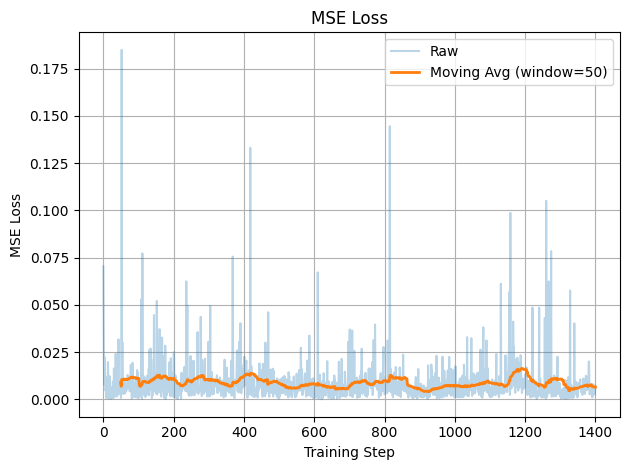

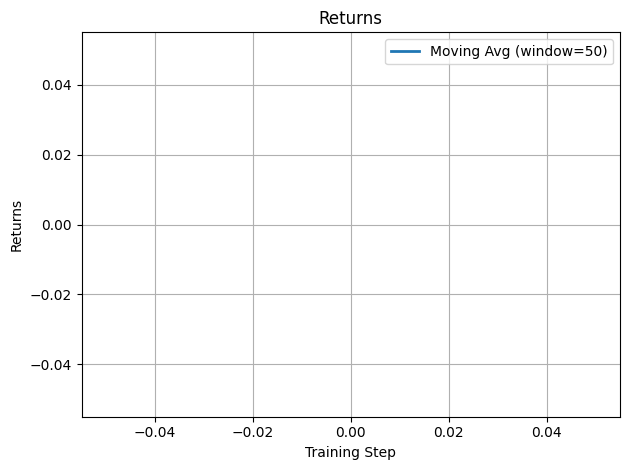

  4%|▍         | 10/250 [01:15<31:17,  7.82s/it]

Saved q_network state_dict to: q_network_final.pth


  8%|▊         | 19/250 [02:25<30:00,  7.79s/it]

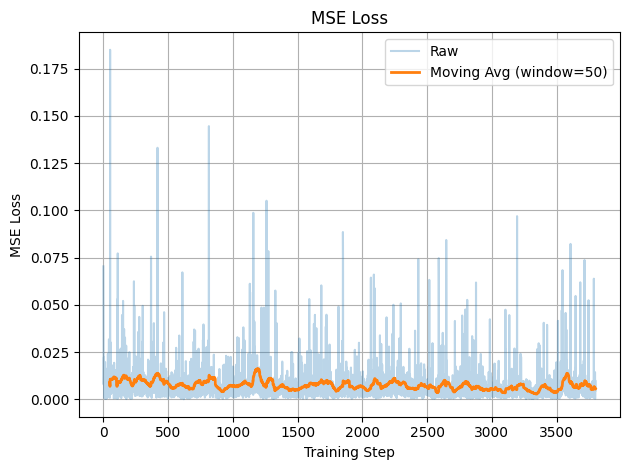

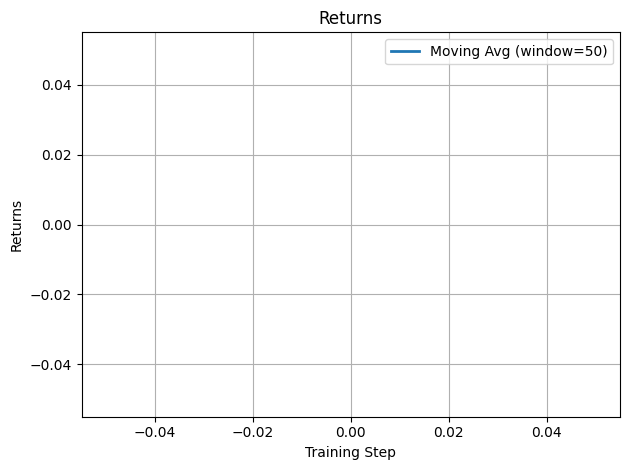

  8%|▊         | 20/250 [02:33<30:13,  7.89s/it]

Saved q_network state_dict to: q_network_final.pth


 12%|█▏        | 29/250 [03:43<28:37,  7.77s/it]

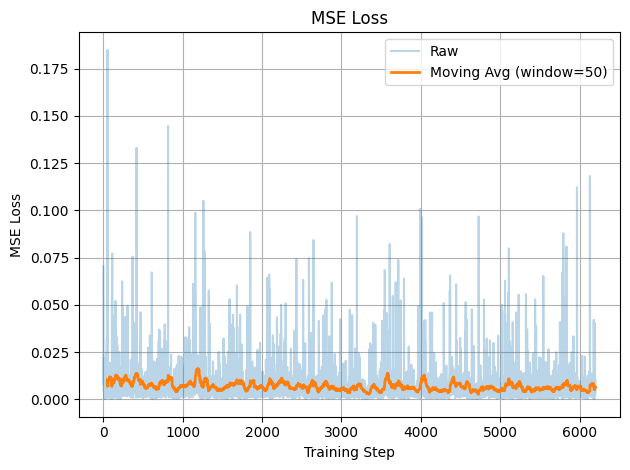

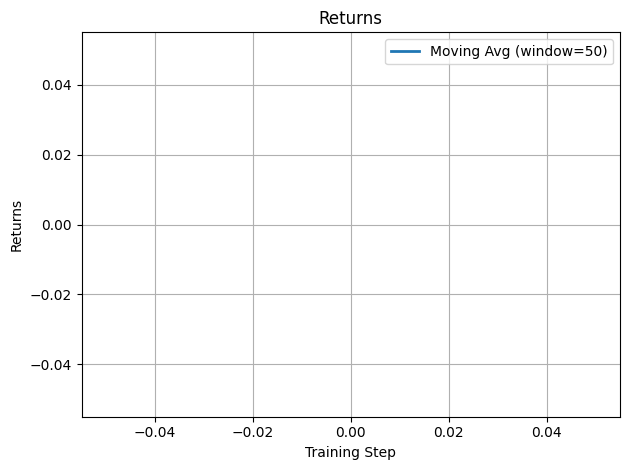

 12%|█▏        | 30/250 [03:51<29:09,  7.95s/it]

Saved q_network state_dict to: q_network_final.pth


 16%|█▌        | 39/250 [05:02<28:08,  8.00s/it]

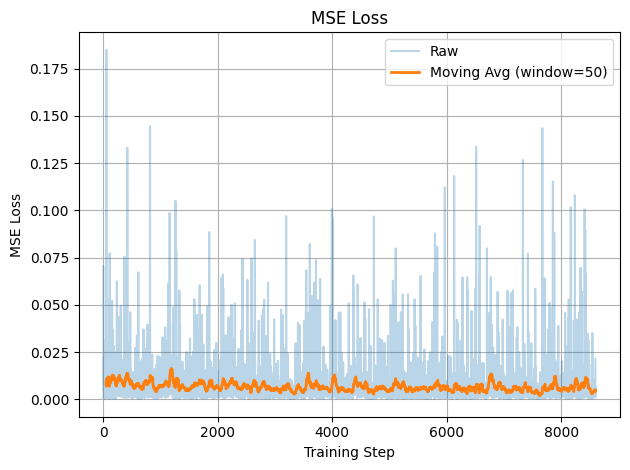

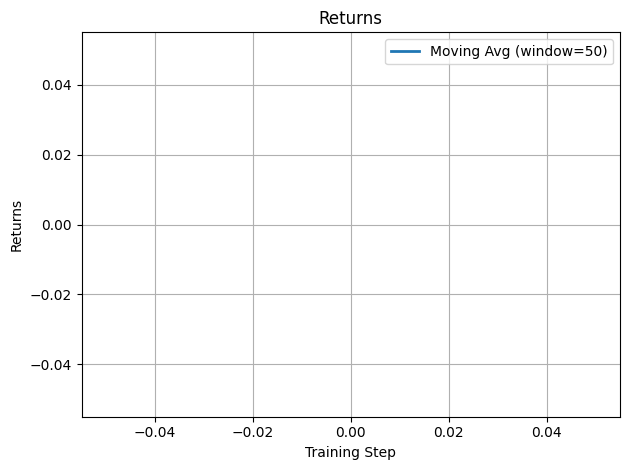

 16%|█▌        | 40/250 [05:10<28:05,  8.03s/it]

Saved q_network state_dict to: q_network_final.pth


 20%|█▉        | 49/250 [06:20<25:59,  7.76s/it]

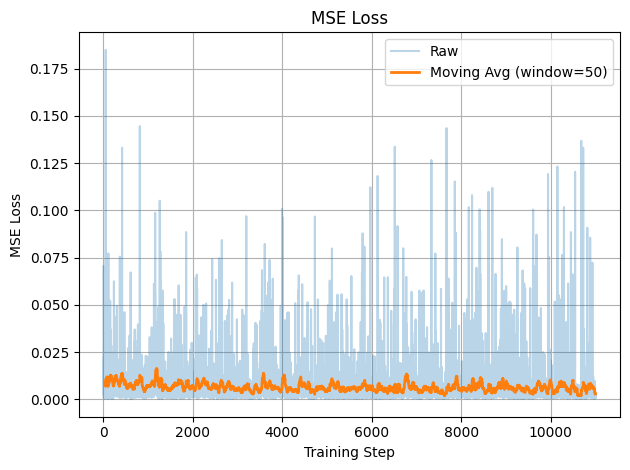

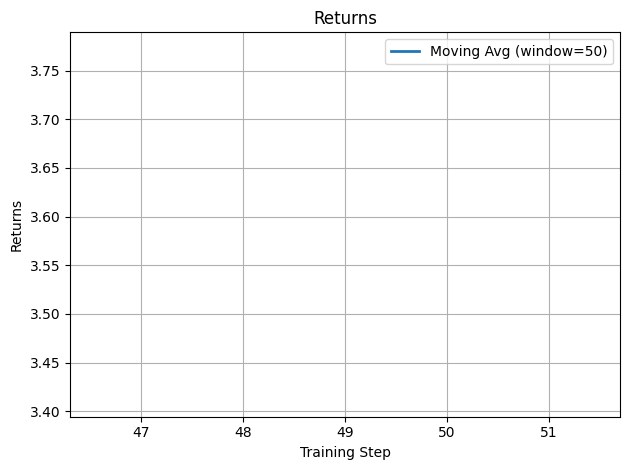

 20%|██        | 50/250 [06:28<26:00,  7.80s/it]

Saved q_network state_dict to: q_network_final.pth


 24%|██▎       | 59/250 [07:39<24:55,  7.83s/it]

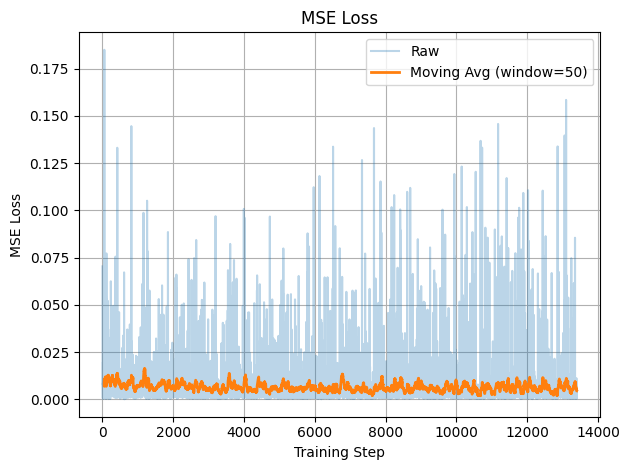

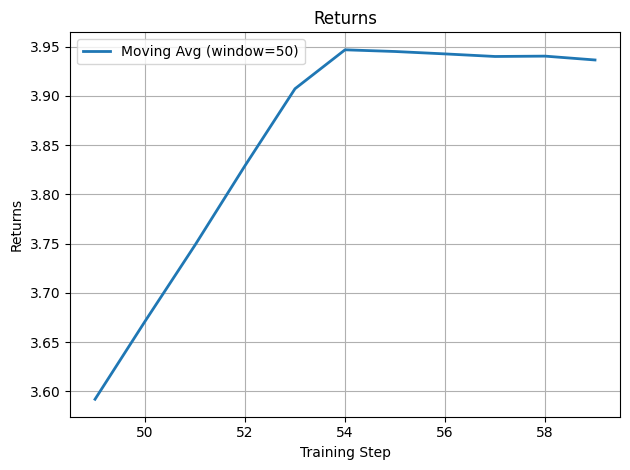

 24%|██▍       | 60/250 [07:46<24:41,  7.80s/it]

Saved q_network state_dict to: q_network_final.pth


 28%|██▊       | 69/250 [08:57<23:52,  7.91s/it]

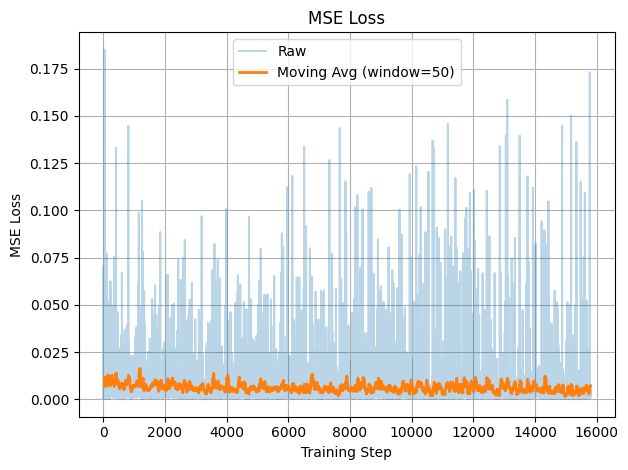

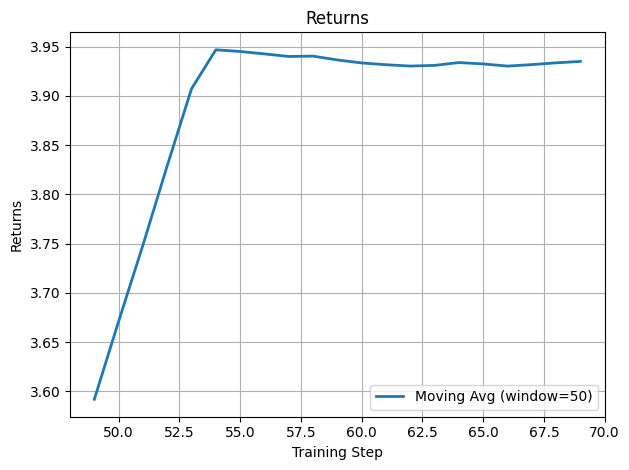

 28%|██▊       | 70/250 [09:05<23:43,  7.91s/it]

Saved q_network state_dict to: q_network_final.pth


 32%|███▏      | 79/250 [10:16<22:29,  7.89s/it]

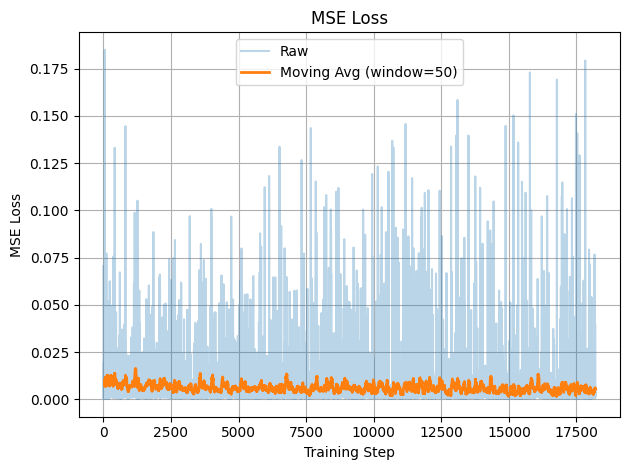

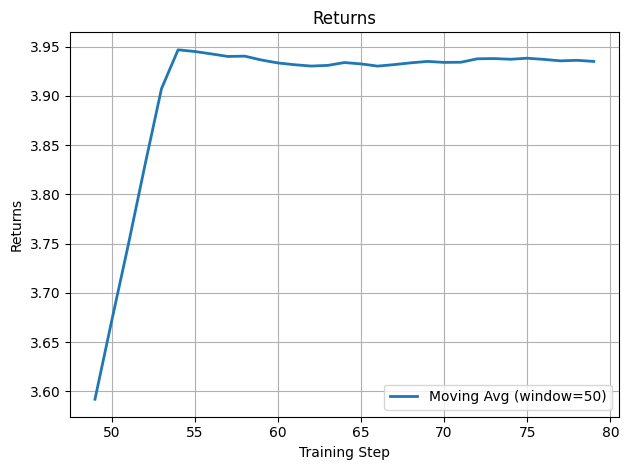

 32%|███▏      | 80/250 [10:24<22:43,  8.02s/it]

Saved q_network state_dict to: q_network_final.pth


 36%|███▌      | 89/250 [11:35<21:17,  7.94s/it]

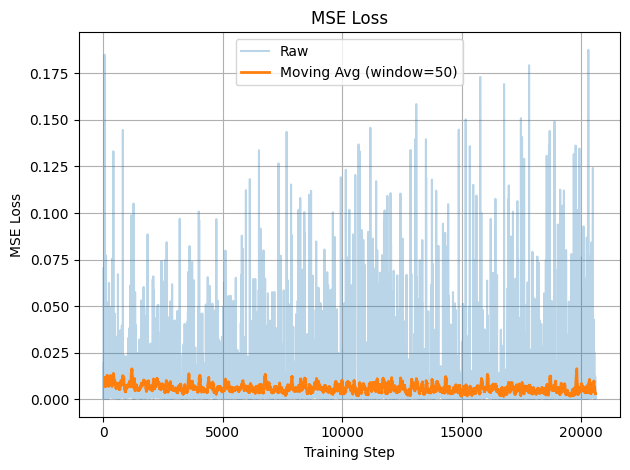

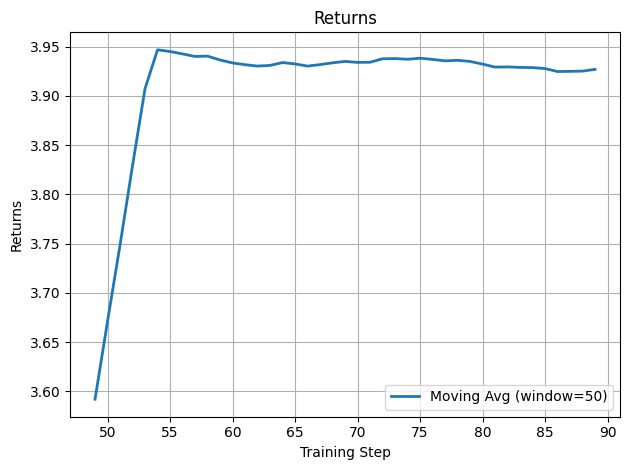

 36%|███▌      | 90/250 [11:43<21:02,  7.89s/it]

Saved q_network state_dict to: q_network_final.pth


 40%|███▉      | 99/250 [12:54<19:56,  7.92s/it]

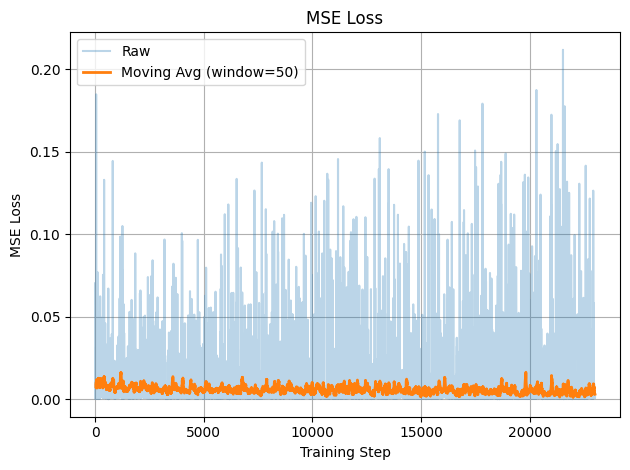

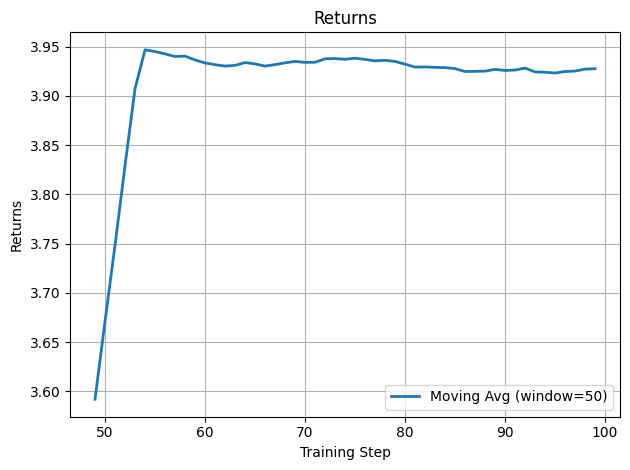

 40%|████      | 100/250 [13:02<19:52,  7.95s/it]

Saved q_network state_dict to: q_network_final.pth


 44%|████▎     | 109/250 [14:14<18:44,  7.97s/it]

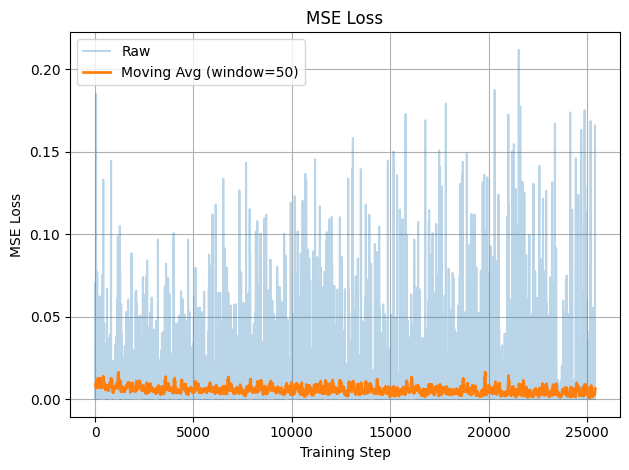

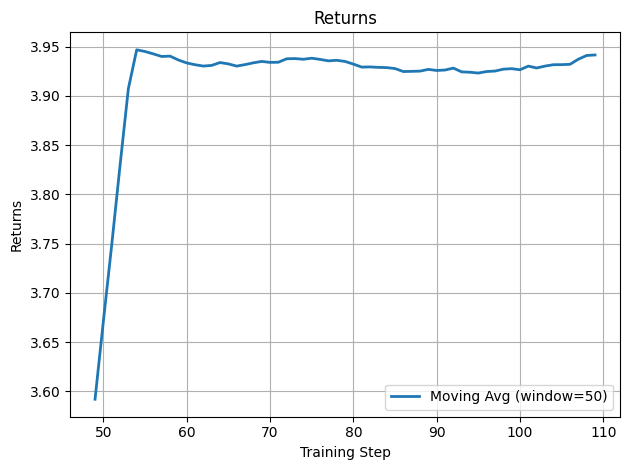

 44%|████▍     | 110/250 [14:22<18:34,  7.96s/it]

Saved q_network state_dict to: q_network_final.pth


 48%|████▊     | 119/250 [15:33<17:16,  7.91s/it]

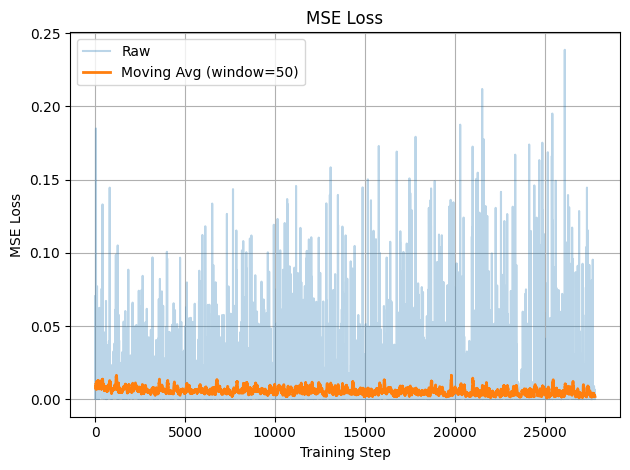

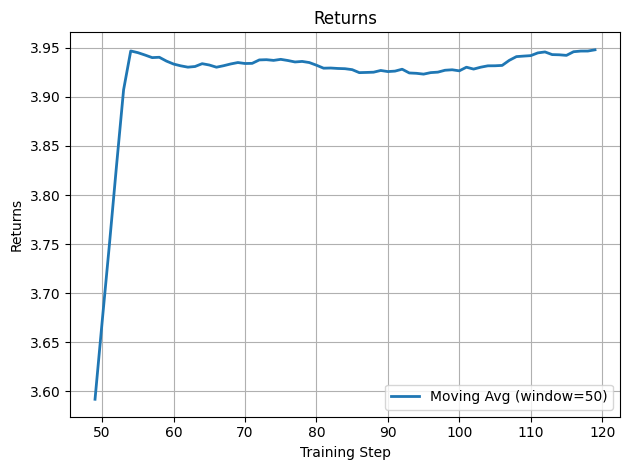

 48%|████▊     | 120/250 [15:41<17:14,  7.96s/it]

Saved q_network state_dict to: q_network_final.pth


 52%|█████▏    | 129/250 [16:51<15:55,  7.90s/it]

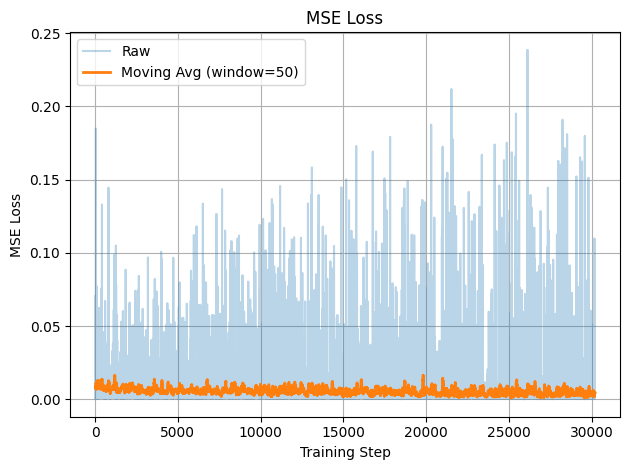

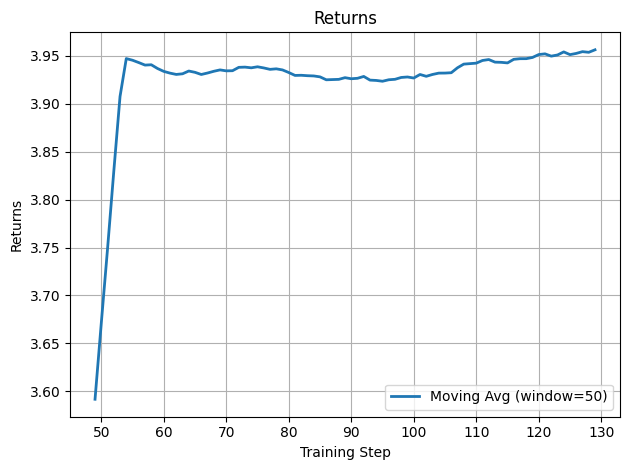

 52%|█████▏    | 130/250 [16:59<15:51,  7.93s/it]

Saved q_network state_dict to: q_network_final.pth


 56%|█████▌    | 139/250 [18:10<14:30,  7.85s/it]

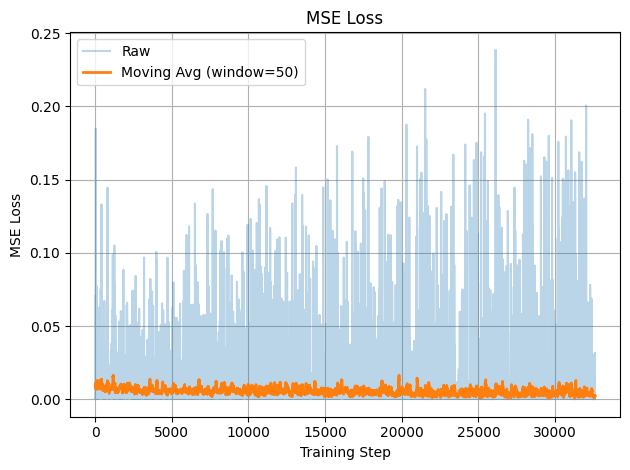

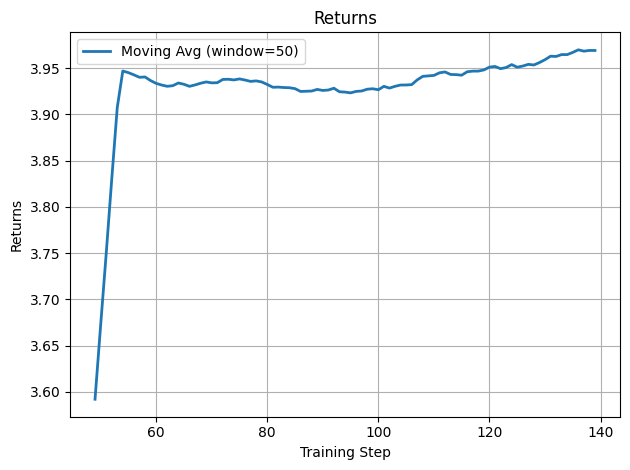

 56%|█████▌    | 140/250 [18:18<14:26,  7.87s/it]

Saved q_network state_dict to: q_network_final.pth


 60%|█████▉    | 149/250 [19:29<13:19,  7.91s/it]

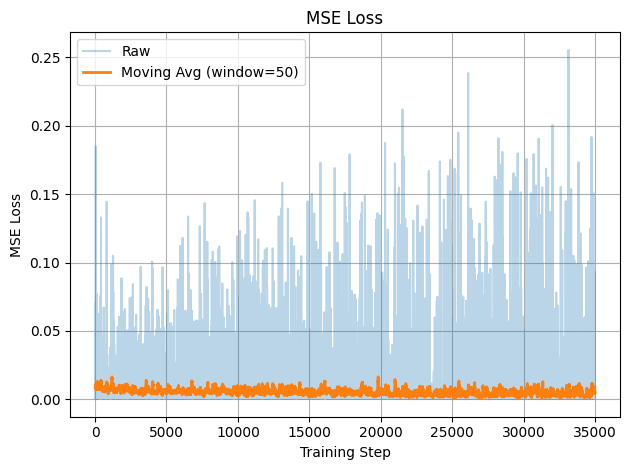

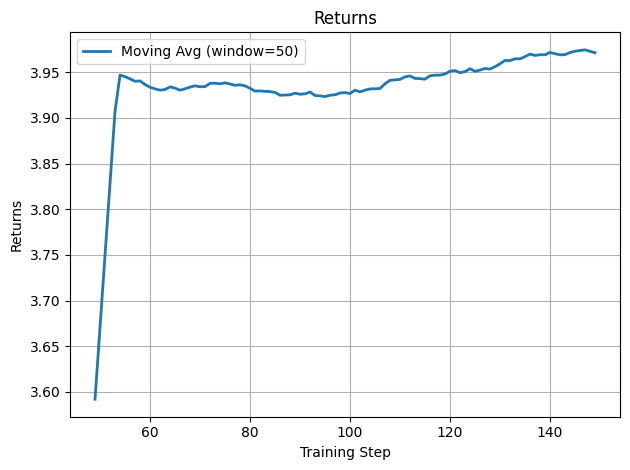

 60%|██████    | 150/250 [19:37<13:14,  7.95s/it]

Saved q_network state_dict to: q_network_final.pth


 64%|██████▎   | 159/250 [20:49<12:04,  7.96s/it]

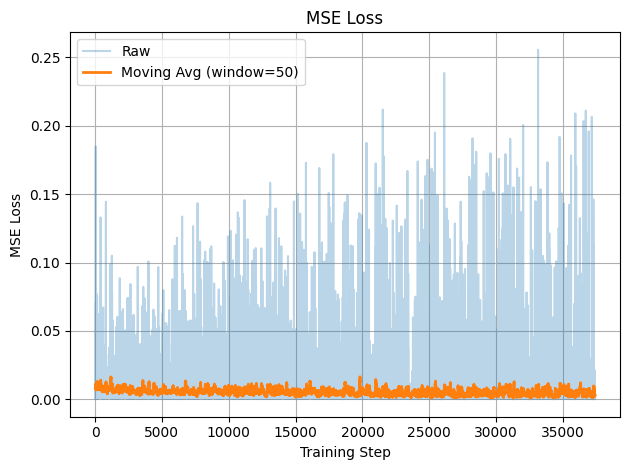

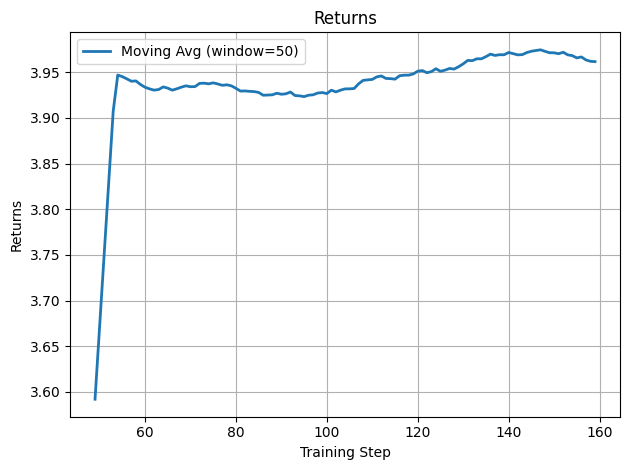

 64%|██████▍   | 160/250 [20:57<12:04,  8.05s/it]

Saved q_network state_dict to: q_network_final.pth


 68%|██████▊   | 169/250 [22:09<10:49,  8.02s/it]

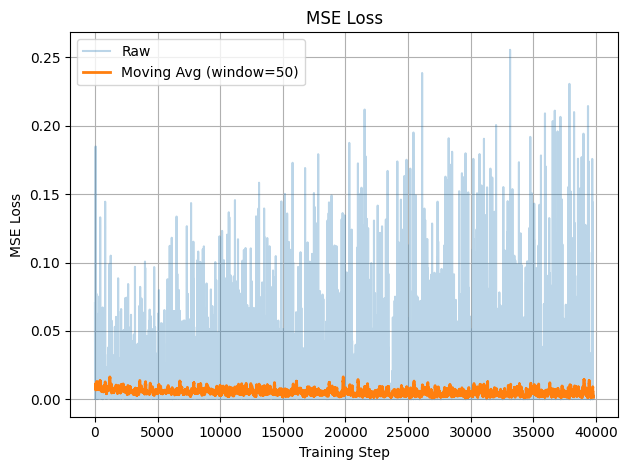

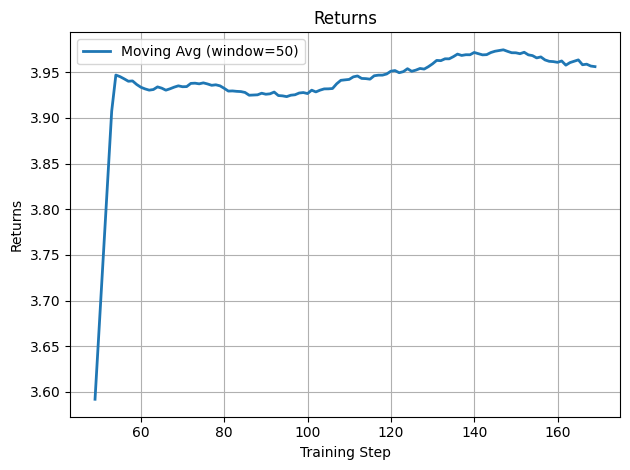

 68%|██████▊   | 170/250 [22:17<10:49,  8.12s/it]

Saved q_network state_dict to: q_network_final.pth


 72%|███████▏  | 179/250 [23:29<09:24,  7.95s/it]

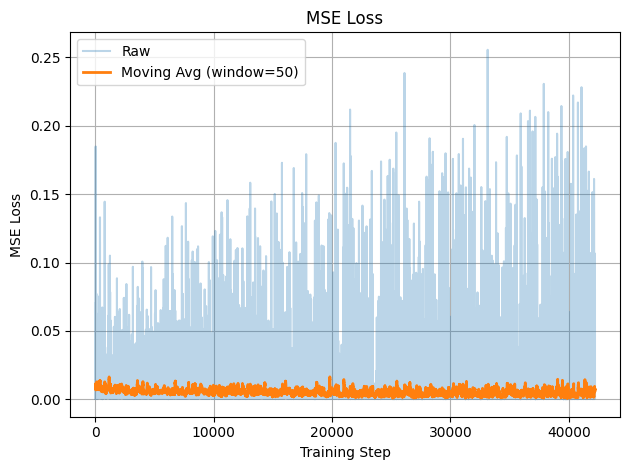

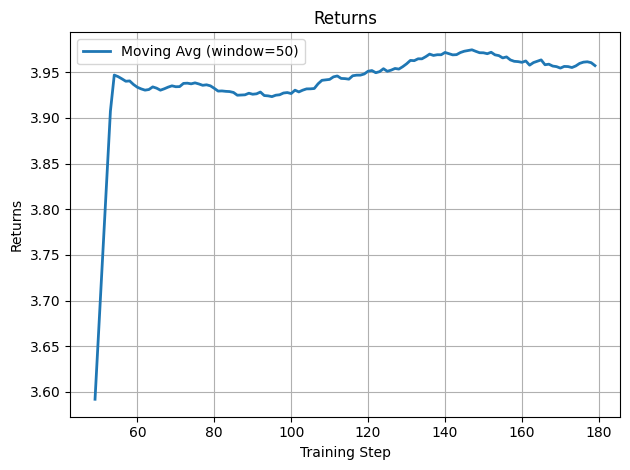

 72%|███████▏  | 180/250 [23:37<09:25,  8.08s/it]

Saved q_network state_dict to: q_network_final.pth


 76%|███████▌  | 189/250 [24:48<08:09,  8.03s/it]

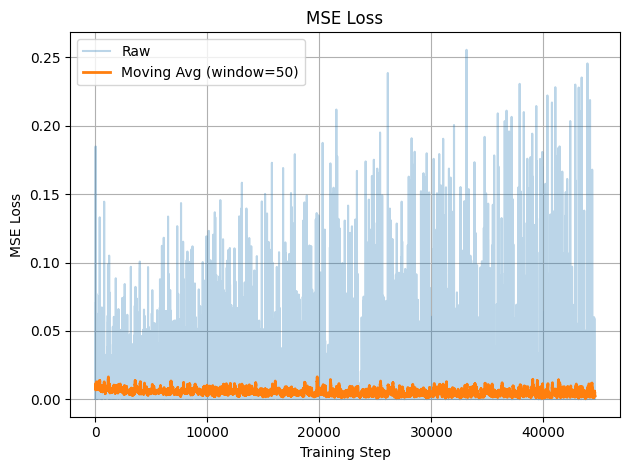

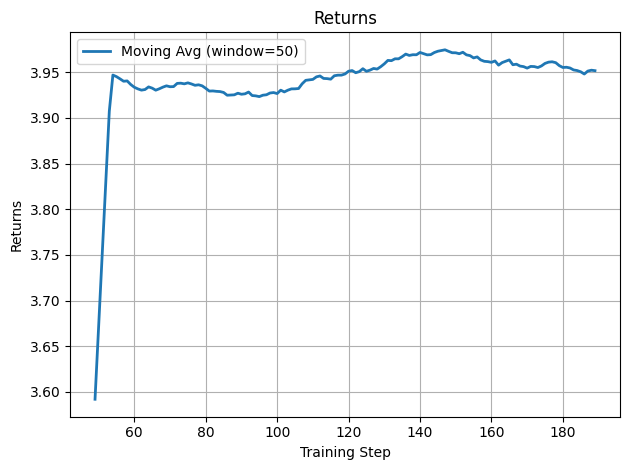

 76%|███████▌  | 190/250 [24:57<08:12,  8.20s/it]

Saved q_network state_dict to: q_network_final.pth


 80%|███████▉  | 199/250 [26:09<06:45,  7.95s/it]

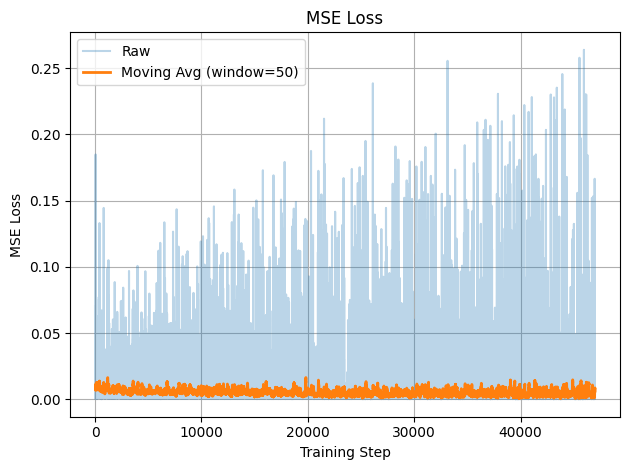

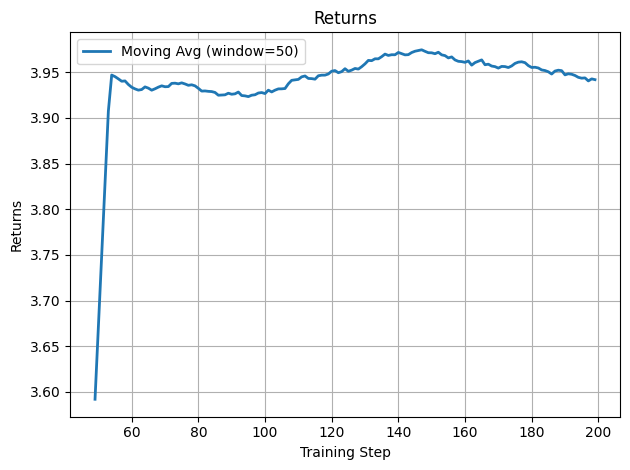

 80%|████████  | 200/250 [26:17<06:43,  8.08s/it]

Saved q_network state_dict to: q_network_final.pth


 84%|████████▎ | 209/250 [27:29<05:23,  7.90s/it]

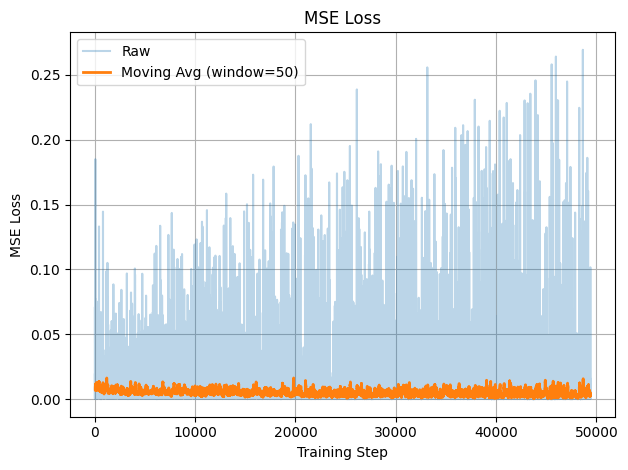

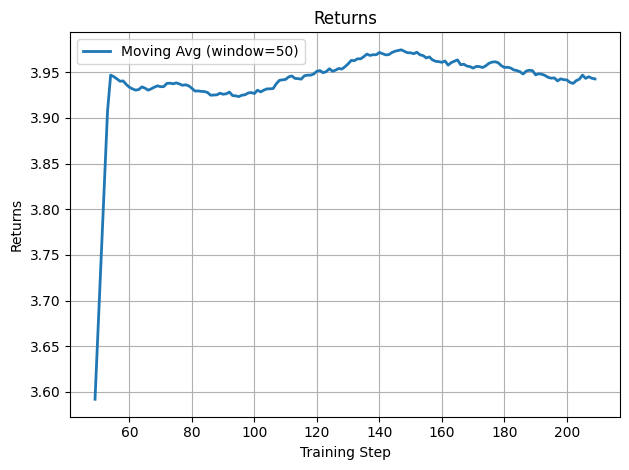

 84%|████████▍ | 210/250 [27:37<05:23,  8.09s/it]

Saved q_network state_dict to: q_network_final.pth


 88%|████████▊ | 219/250 [28:48<04:03,  7.84s/it]

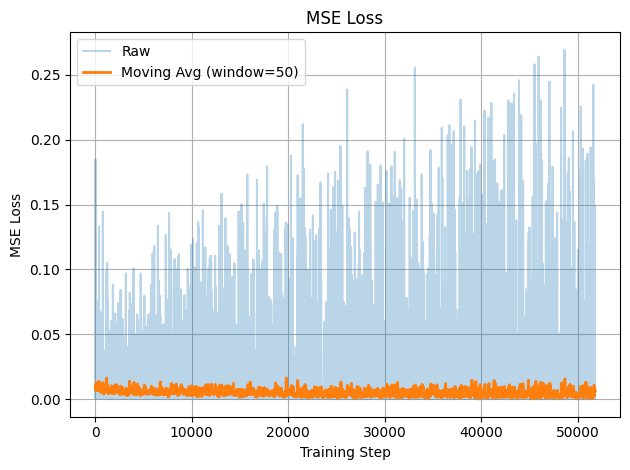

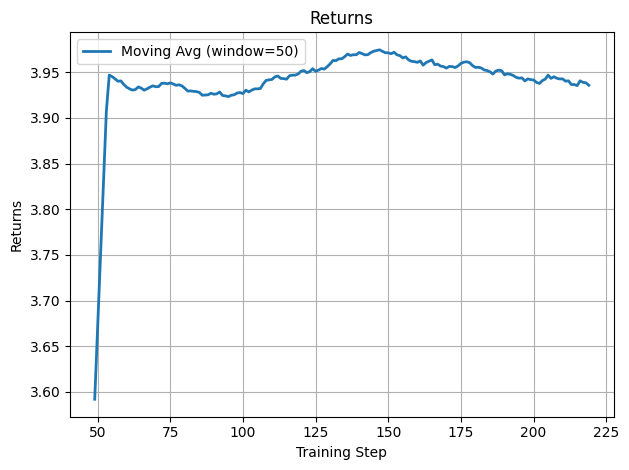

 88%|████████▊ | 220/250 [28:57<04:01,  8.04s/it]

Saved q_network state_dict to: q_network_final.pth


 92%|█████████▏| 229/250 [30:08<02:46,  7.92s/it]

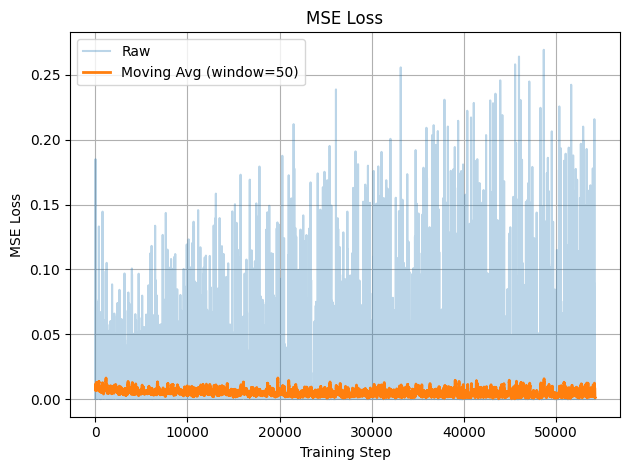

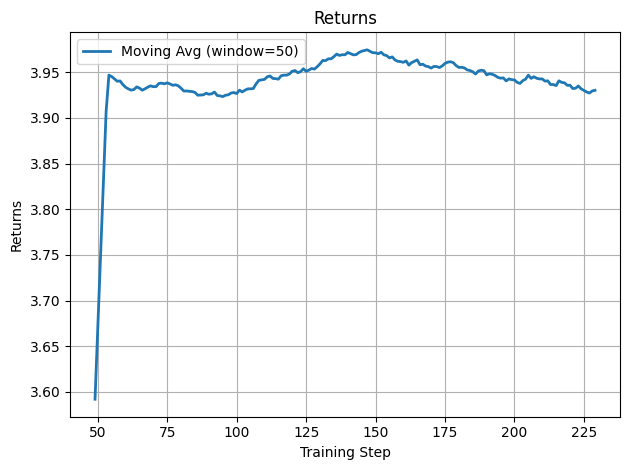

 92%|█████████▏| 230/250 [30:16<02:41,  8.05s/it]

Saved q_network state_dict to: q_network_final.pth


 96%|█████████▌| 239/250 [31:28<01:27,  7.92s/it]

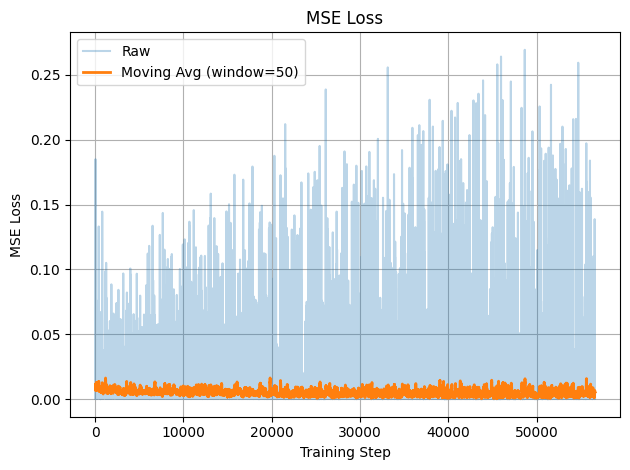

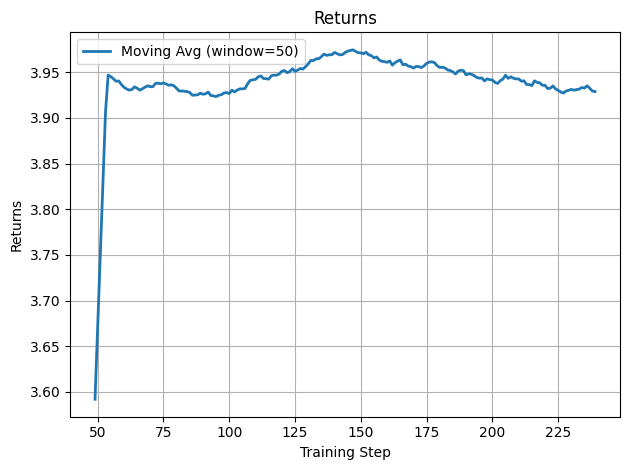

 96%|█████████▌| 240/250 [31:36<01:20,  8.10s/it]

Saved q_network state_dict to: q_network_final.pth


100%|█████████▉| 249/250 [32:48<00:07,  7.89s/it]

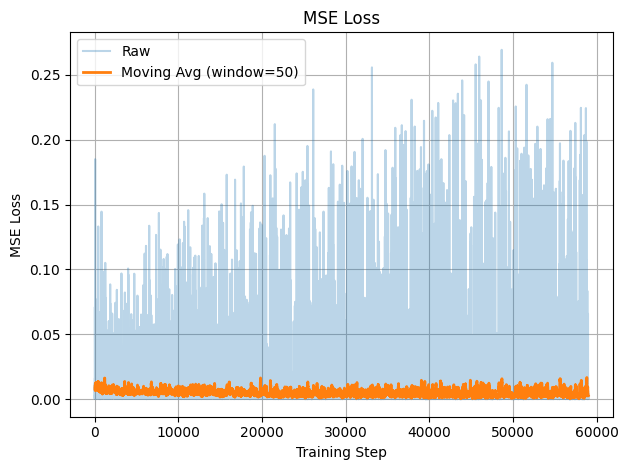

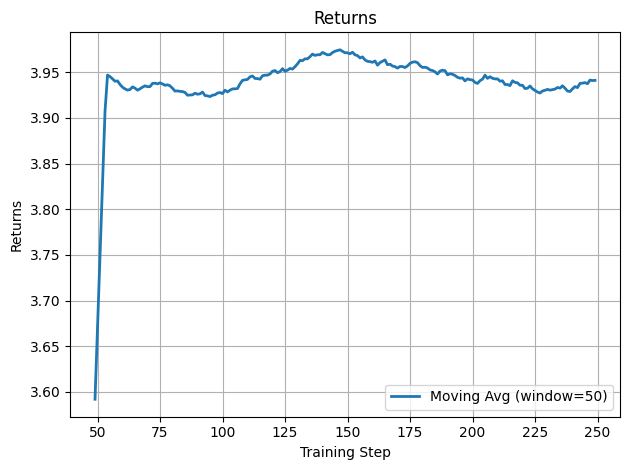

100%|██████████| 250/250 [32:56<00:00,  7.91s/it]

Saved q_network state_dict to: q_network_final.pth


In [ ]:
env = KombuchaGym()
env = PreprocessEnv(env)

load_q_network(q_network, TRAINED_NN_PTH)
target_q_network.load_state_dict(q_network.state_dict())

stats = deep_sarsa(q_network, policy, episodes = 250, alpha=0.0001, batch_size=64)

In [ ]:
env_post = KombuchaGym(max_steps=50)
env_post = PreprocessEnv(env_post)
post_training_logs = run_q_network_policy_episode(env_post, q_network, max_steps=50)

In [ ]:
post_df = pd.DataFrame([
    {
        "step": entry["step"],
        "pH": entry["pH"],
        "dilution": entry["dilution"],
        "reward": entry["reward"],
        "action": entry["action_q_network"],
        **{f"subpop_{k}": v for k, v in entry["subpop_counts"].items()},
        **{f"metabolite_{k}": v for k, v in entry["metabolite_concentrations"].items()},
        "phase": "post-training"
    }
    for entry in post_training_logs
])


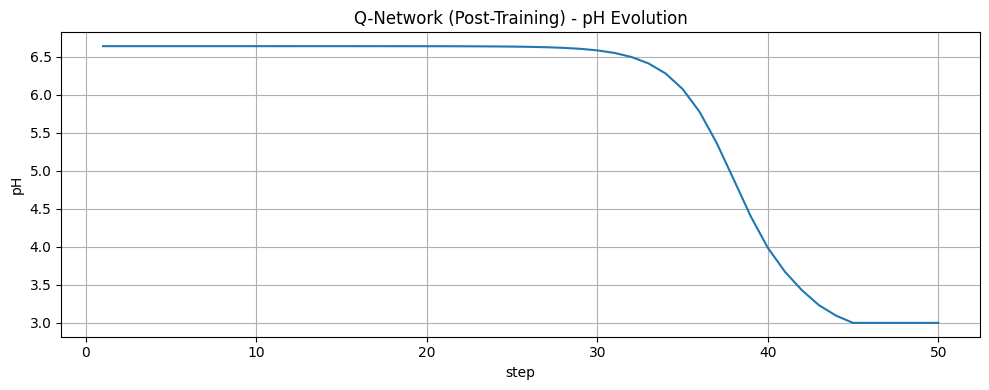

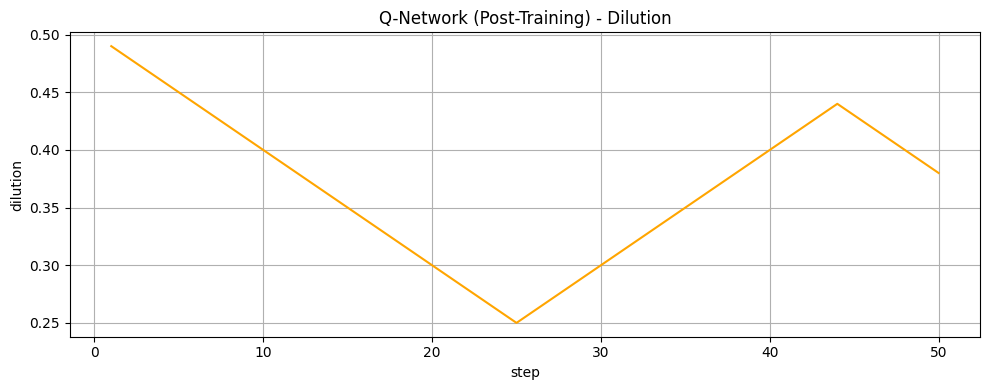

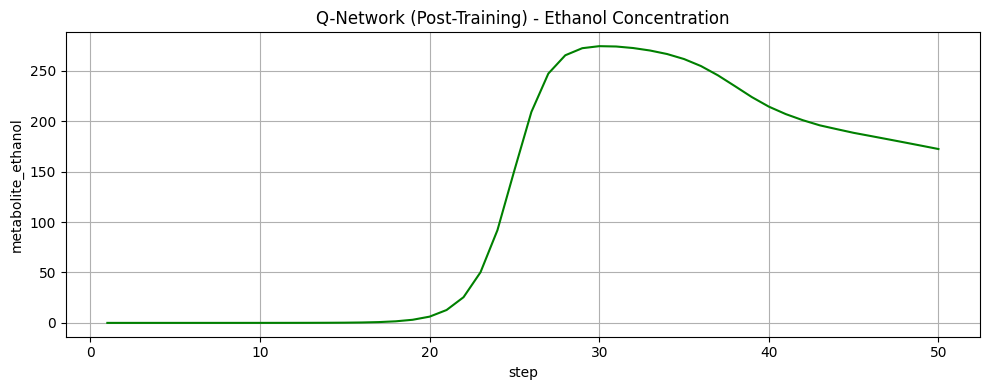

In [ ]:
plt.figure(figsize=(10, 4))
sns.lineplot(data=post_df, x="step", y="pH")
plt.title("Q-Network (Post-Training) - pH Evolution")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.lineplot(data=post_df, x="step", y="dilution", color="orange")
plt.title("Q-Network (Post-Training) - Dilution")
plt.grid(True)
plt.tight_layout()
plt.show()

if "metabolite_ethanol" in post_df.columns:
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=post_df, x="step", y="metabolite_ethanol", color="green")
    plt.title("Q-Network (Post-Training) - Ethanol Concentration")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

